In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit as cf
import os
import pandas as pd
from math import floor
import scipy.stats as stats

In [2]:
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['font.size'] = 15
mpl.rcParams['errorbar.capsize'] = 3
mpl.rcParams['lines.markeredgewidth'] = 1
mpl.rcParams['axes.axisbelow'] = True

In [3]:
dcmls = lambda x : -int(floor(np.log10(abs(x))))

round_error = lambda value,rounder : np.round(value,dcmls(rounder))

def chi2(y,y_err,x,func,popt):
    y_ajuste = func(x,*popt)
    chi_cuadrado = np.sum(((y-y_ajuste)/y_err)**2)
    return chi_cuadrado

def chi2_red(y,y_err,x,func,popt):
    chi_cuadrado = chi2(y,y_err,x,func,popt)
    puntos = len(y)
    params = len(popt)
    grados_lib = puntos - params - 1
    chi_reducido = chi_cuadrado/grados_lib
    return chi_reducido

def pvalue(y,y_err,x,func,popt):
    chi_cuadrado = chi2(y,y_err,x,func,popt)
    puntos = len(y)
    params = len(popt)
    grados_lib = puntos - params - 1
    pvalor = stats.chi2.sf(chi_cuadrado,grados_lib)
    return pvalor

In [4]:
df = pd.read_csv('caract/mults3.csv')
V0_1 = np.mean(df.V1)
V0_2 = np.mean(df.V2)
V0_3 = np.mean(df.V3[df.V3<0.002])
print(V0_1*1000,V0_2*1000,V0_3*1000)

df = pd.read_csv('caract/3cuplas.csv')
df.V1 -= V0_1
df.V2 -= V0_2
df.V3 -= V0_3
Vc_1 = np.mean(df.V1)
Vc_2 = np.mean(df.V2)
Vc_3 = np.mean(df.V3)
dV1 = Vc_1 - Vc_2
dV3 = Vc_3 - Vc_2
print(dV1*1000,dV3*1000)

-0.24237812499999997 -0.005738416666666665 -0.0023332842105263105
0.4045866302083333 0.3296623050438596


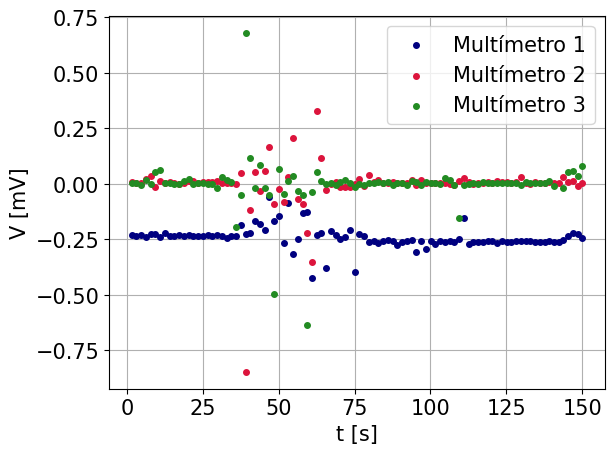

In [5]:
df = pd.read_csv('caract/mults3.csv')

plt.scatter(df.t,df.V1*1000,c='navy',label='Multímetro 1')
plt.scatter(df.t,df.V2*1000,c='crimson',label='Multímetro 2')
plt.scatter(df.t[df.V3<0.002],df.V3[df.V3<0.002]*1000,c='forestgreen',label='Multímetro 3')
plt.grid()
plt.legend()
plt.xlabel('t [s]')
plt.ylabel('V [mV]')
plt.tight_layout()
plt.savefig('plots/offsets.png')

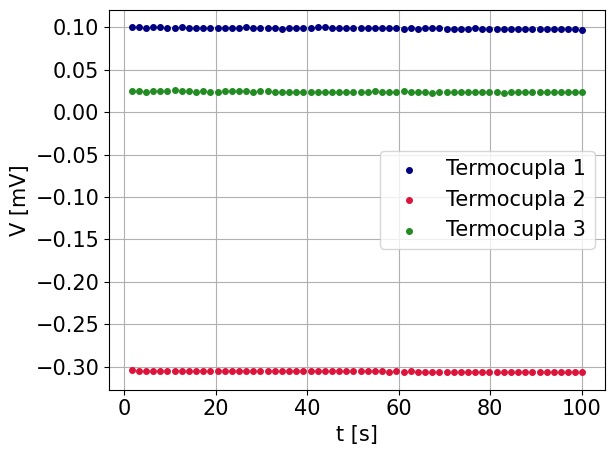

In [6]:
df = pd.read_csv('caract/3cuplas.csv')
df.V1 -= V0_1
df.V2 -= V0_2
df.V3 -= V0_3

plt.scatter(df.t,df.V1*1000,c='navy',label='Termocupla 1')
plt.scatter(df.t,df.V2*1000,c='crimson',label='Termocupla 2')
plt.scatter(df.t,df.V3*1000,c='forestgreen',label='Termocupla 3')
plt.grid()
plt.legend()
plt.xlabel('t [s]')
plt.ylabel('V [mV]')
plt.tight_layout()
plt.savefig('plots/cuplas.png')

In [5]:
def open_df(file,V3=None):
    df = pd.read_csv(file)
    df.drop(df.columns[0],axis=1,inplace=True)
    df.V1 -= V0_1
    df.V1 -= dV1
    df.V2 -= V0_2
    if V3 is not None:
        df.V3 -= V0_3
        if V3 == 'T':
            df.V3 -= dV3
    return df

In [6]:
from tc import Thermocouple

termoloco = Thermocouple()

temp = lambda V : termoloco.mv_to_typek(V*1000)

def temps(Vs):
    Ts = []
    for V in Vs:
        Ts.append(temp(V))
    return np.array(Ts)

In [7]:
def open_saltos(folder,reverse=False,V3=True,weird=False):
    files = os.listdir(f'{folder}')
    names = []
    for i in range(len(files)):
        if files[i].endswith('.csv'):
            names.append(float(files[i][:-4]))
    names = np.sort(np.array(names))
    if reverse:
        for i in range(len(names)-1):
            names[i] = names[i+1]
        names[-1] = 0.0
    
    df = pd.read_csv(f'{folder}/{names[0]}.csv')
    for name in names[1:]:
        df = pd.concat([df,pd.read_csv(f'{folder}/{name}.csv')])
    if weird:
        df.drop(columns=df.columns[:2],axis=1,inplace=True)
    else:
        df.drop(columns=df.columns[:1],axis=1,inplace=True)
    df.reset_index(drop=True,inplace=True)
    df.V1 -= V0_1
    df.V2 -= V0_2
    df.V1 -= dV1
    if V3:
        df.V3 -= V0_3
    return df

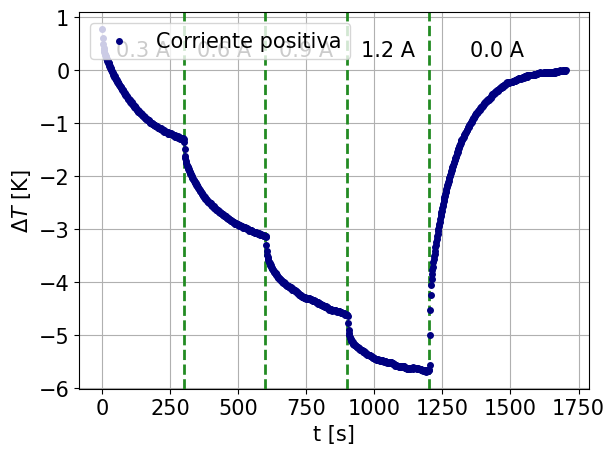

In [19]:
df_pos = open_saltos('seebeck/saltos pos',V3=False)

corrientes = [0.3,0.6,0.9,1.2,0.0]

df_pos.sort_values(df_pos.columns[0],inplace=True)
df_pos.reset_index(drop=True,inplace=True)

temp1_pos = temps(df_pos.V1)
temp2_pos = temps(df_pos.V2)
dT_pos = temp2_pos - temp1_pos
dT_pos -= dT_pos[-1]

plt.scatter(df_pos.t,dT_pos,c='navy',label='Corriente positiva',zorder=2)
for i in range(1,5):
    plt.axvline(300*i,c='forestgreen',ls='--',zorder=1)
for i in range(4):
    plt.text(300*i+150, dT_pos.max() * 0.35,  # Adjust the y position if needed
             f'{corrientes[i]} A', c='k', ha='center')
plt.text(300*4+250, dT_pos.max() * 0.35,  # Adjust the y position if needed
             f'{corrientes[-1]} A', c='k', ha='center')
#for i in range(3,5):
#    plt.text(100*i+50, max(dT_pos.max(), dT_neg.max()) * 0.35,  # Adjust the y position if needed
#             f'{corrientes[i]} A', c='k', ha='center')


plt.legend(loc=2)
plt.grid()
plt.xlabel('t [s]')
plt.ylabel(r'$\Delta T$ [K]')
plt.tight_layout()

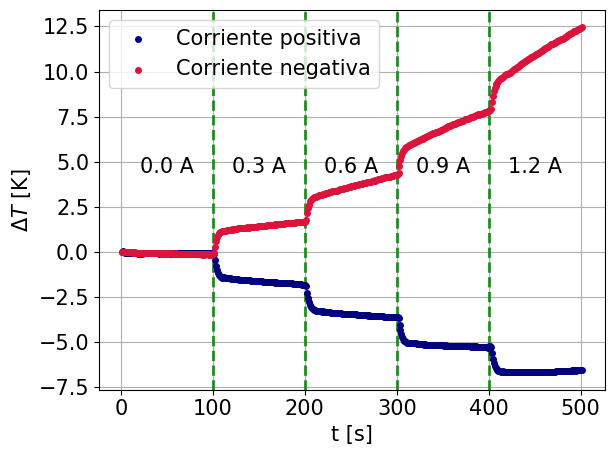

In [8]:
df_pos = open_saltos('saltos/segundo largo pos',V3=False)
df_neg = open_saltos('saltos/segundo largo neg',V3=False)

corrientes = [0.0,0.3,0.6,0.9,1.2]

df_pos.sort_values(df_pos.columns[0],inplace=True)
df_pos.reset_index(drop=True,inplace=True)
df_neg.sort_values(df_neg.columns[0],inplace=True)
df_neg.reset_index(drop=True,inplace=True)

df_pos = df_pos[:480]
df_neg = df_neg[:480]

temp1_pos = temps(df_pos.V1)
temp2_pos = temps(df_pos.V2)
dT_pos = temp2_pos - temp1_pos
dT_pos -= dT_pos[0]

temp1_neg = temps(df_neg.V1)
temp2_neg = temps(df_neg.V2)
dT_neg = temp2_neg - temp1_neg
dT_neg -= dT_neg[0]

plt.scatter(df_pos.t,dT_pos,c='navy',label='Corriente positiva',zorder=2)
plt.scatter(df_neg.t,dT_neg,c='crimson',label='Corriente negativa',zorder=3)
for i in range(1,5):
    plt.axvline(100*i,c='forestgreen',ls='--',zorder=1)
for i in range(5):
    plt.text(100*i+50,max(dT_pos.max(),dT_neg.max())*0.35,f'{corrientes[i]} A',c='k',ha='center')

plt.legend(loc=2)
plt.grid()
plt.xlabel('t [s]')
plt.ylabel(r'$\Delta T$ [K]')
plt.tight_layout()
plt.savefig('plots/saltos_both.png')

In [9]:
def error_voltajes(V,range_value=0.1,tipo='90-day'):
    if tipo == '90-day':
        reading_accuracy = 0.000030  # 0.0030%
        range_accuracy = 0.000030  # 0.0030%
    elif tipo == '1-year':
        reading_accuracy = 0.000040  # 0.0040%
        range_accuracy = 0.000035  # 0.0035%
    else:
        raise ValueError('Tipo inválido')
    
    reading_uncertainty = reading_accuracy * abs(V)
    range_uncertainty = range_accuracy * range_value
    total_uncertainty = reading_uncertainty + range_uncertainty
    return total_uncertainty

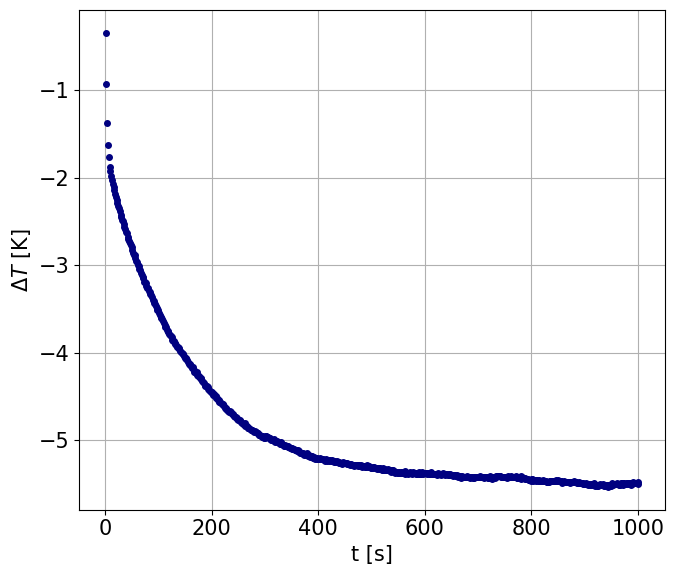

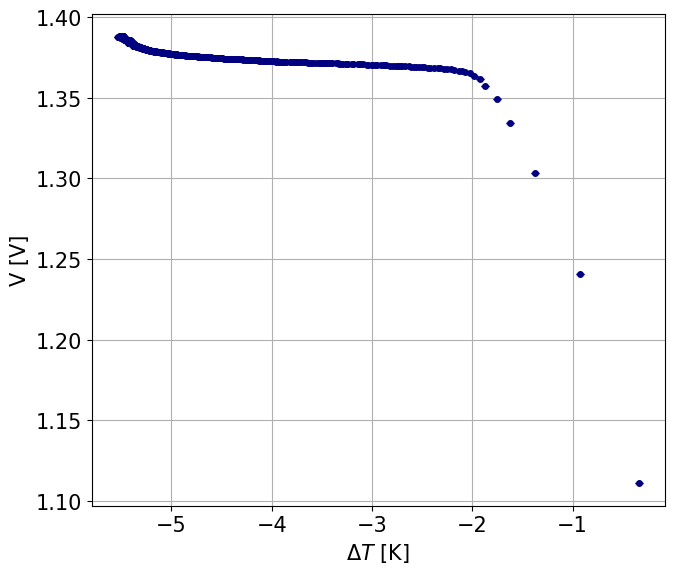

In [10]:
df = open_df('long_on.csv',V3=True)

temp1 = temps(df.V1)
temp2 = temps(df.V2)
dT = temp2-temp1
df.V3 = -df.V3

err_V3 = error_voltajes(df.V3,tipo='1-year')

fig = plt.figure(figsize=(7,6))
plt.scatter(df.t,dT,c='navy')
plt.grid()
plt.xlabel('t [s]')
plt.ylabel(r'$\Delta T$ [K]')
plt.tight_layout()
plt.savefig('plots/long_on_T.png')
plt.show()
plt.close()

fig = plt.figure(figsize=(7,6))
plt.scatter(dT,df.V3,c='navy',zorder=2)
plt.errorbar(dT,df.V3,yerr=err_V3,fmt='none',ecolor='navy',zorder=1)
plt.grid()
plt.xlabel(r'$\Delta T$ [K]')
plt.ylabel('V [V]')
plt.tight_layout()
plt.savefig('plots/full_V_on.png')
plt.show()
plt.close()

In [11]:
from sklearn.linear_model import LinearRegression
lineal = lambda x,a,b : a*x+b
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import norm

In [13]:
# CORRER ESTE ANTES DEL PRIMER AJUSTE, EL OTRO ANTES DEL SEGUNDO
def determine_linear_range(dT, V3, lower_start=1.35, lower_end=1.39, upper_start=1.35, upper_end=1.385, step=0.0005,min_points=50,max_points=100):
    if isinstance(dT, (pd.Series, pd.DataFrame)):
        dT = dT.values
    if isinstance(V3, (pd.Series, pd.DataFrame)):
        V3 = V3.values
    
    if len(dT) != len(V3):
        raise ValueError("dT and V3 must have the same length")

    best_r_squared = -np.inf
    best_model = None
    best_x = None
    best_y = None
    best_y_pred = None
    best_residuals = None
    
    lower_thresholds = np.arange(lower_start, lower_end, step)
    upper_thresholds = np.arange(upper_start, upper_end, step)
    
    for lower_threshold in lower_thresholds:
        for upper_threshold in upper_thresholds:
            if upper_threshold <= lower_threshold:
                continue
            
            # Filter data
            mask = (V3 > lower_threshold) & (V3 < upper_threshold)
            x = dT[mask]
            y = V3[mask]
            
            # Ensure minimum number of points
            if len(x) < min_points:
                continue
            if len(x) > max_points:
                continue
            
            # Reshape x for sklearn (2D array required)
            X = x.reshape(-1, 1)
            
            # Fit linear regression model
            model = LinearRegression()
            model.fit(X, y)
            
            # Predict y-values using the linear model
            y_pred = model.predict(X)
            
            # Calculate R-squared value
            r_squared = model.score(X, y)
            
            if r_squared > best_r_squared:
                best_r_squared = r_squared
                best_model = model
                best_x = x
                best_y = y
                best_y_pred = y_pred
                best_residuals = y - y_pred
    
    return best_model, best_x, best_y, best_y_pred, best_residuals, best_r_squared

Best R-squared: 0.9980016683627612
[-0.00207146]
Linear range: [-3.95321766 -3.0519442 ]


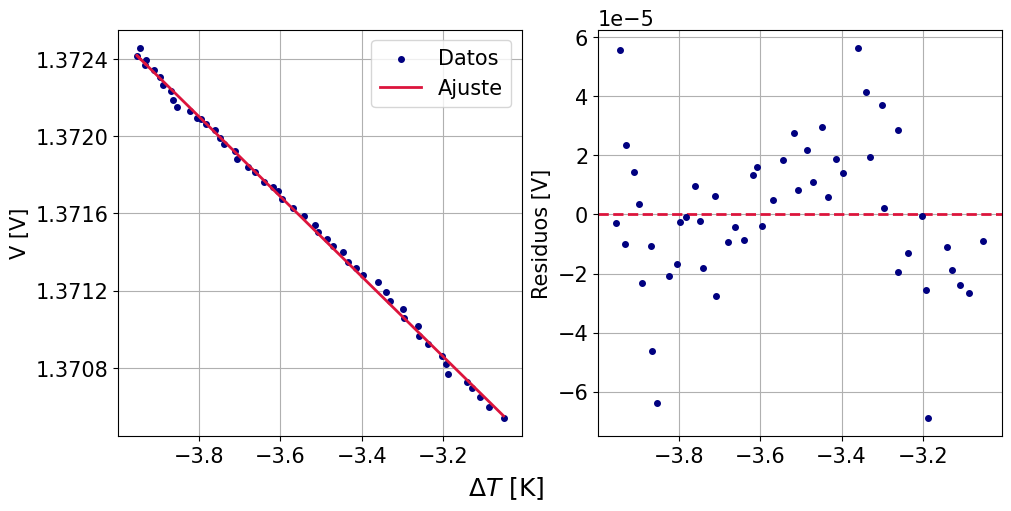

In [14]:
df = open_df('long_on.csv',V3=True)
temp1 = temps(df.V1)
temp2 = temps(df.V2)
my_dT = temp2-temp1
my_V3 = -df.V3

model, x, y, y_pred, residuals, r_squared = determine_linear_range(my_dT,my_V3,min_points=50)

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True,layout='constrained')
axs = axs.flat

axs[0].scatter(x, y, c='navy', label='Datos', zorder=1)
axs[0].plot(x, y_pred, 'crimson', label='Ajuste', zorder=2)
axs[0].grid()
axs[0].legend()
axs[0].set_ylabel('V [V]')
axs[0].yaxis.set_major_locator(mpl.ticker.MaxNLocator(7))

axs[1].scatter(x, residuals, c='navy', zorder=2)
axs[1].axhline(y=0, color='crimson', linestyle='--', zorder=1)
axs[1].grid()
axs[1].set_ylabel('Residuos [V]')
axs[1].yaxis.set_major_locator(mpl.ticker.MaxNLocator(7))

fig.supxlabel(r'$\Delta T$ [K]')

linear_range_on = np.array([min(x),max(x)])

print('Best R-squared:', r_squared)

print(model.coef_)
print(f'Linear range: {linear_range_on}')

plt.savefig('plots/linear_on.png')

[-0.00207046  1.3642332 ]
[5.89409339e-10 7.47035572e-09]
chi2 reducido = 0.3551684189575791
pvalor = 0.999984295349254


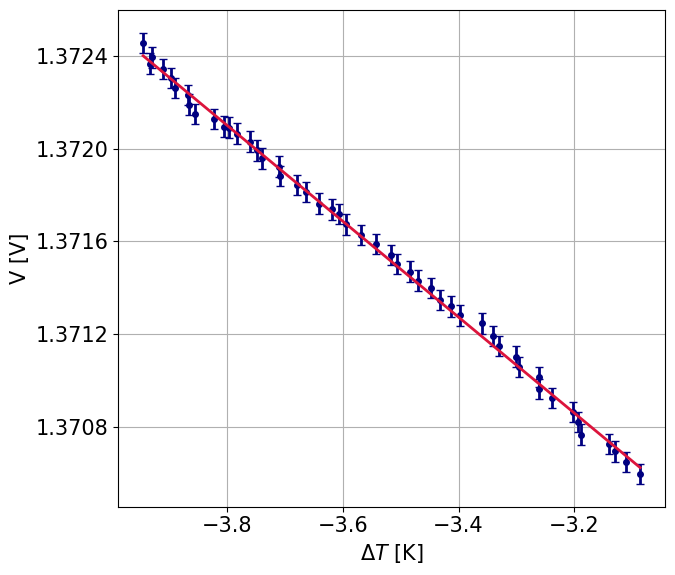

In [15]:
df = open_df('long_on.csv',V3=True)

I = 1 # A

temp1 = temps(df.V1)
temp2 = temps(df.V2)
dT = temp2-temp1
V3 = -df.V3[linear_range_on[0]<dT]
dT = dT[linear_range_on[0]<dT]
V3 = V3[dT<linear_range_on[1]]
dT = dT[dT<linear_range_on[1]]

err_V3 = error_voltajes(V3)

rel_err_1 = err_V3/V3

pars,cov = cf(lineal,dT,V3,absolute_sigma=True,sigma=err_V3)
print(pars)
print(np.diag(cov))

x_adj = np.linspace(min(dT),max(dT))
y_adj = lineal(x_adj,*pars)

fig = plt.figure(figsize=(7,6))

plt.scatter(dT,V3,c='navy',zorder=2)
plt.plot(x_adj,y_adj,c='crimson',label='Ajuste',zorder=3)
plt.errorbar(dT,V3,yerr=err_V3,fmt='none',ecolor='navy',label='Datos',zorder=1)

ax = plt.gca()
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(7))

print(f'chi2 reducido = {chi2_red(V3,err_V3,dT,lineal,pars)}')
print(f'pvalor = {pvalue(V3,err_V3,dT,lineal,pars)}')

plt.grid()
plt.xlabel(r'$\Delta T$ [K]')
plt.ylabel('V [V]')
plt.tight_layout()
plt.savefig('plots/seebeck_on.png')
plt.show()
plt.close()

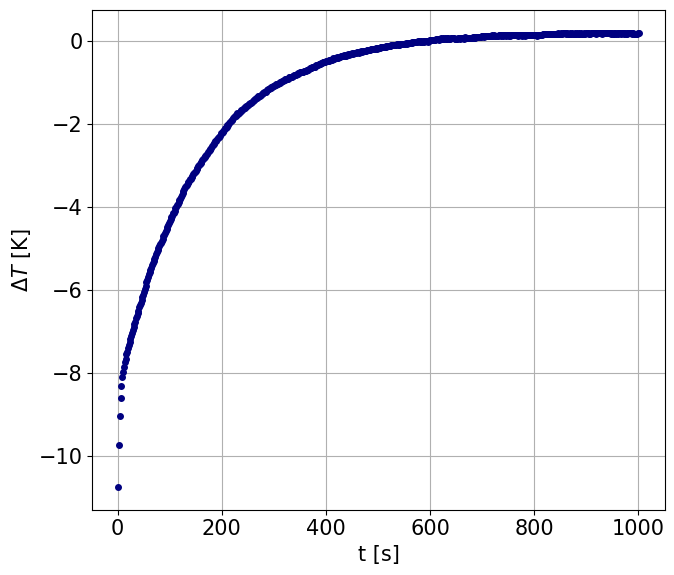

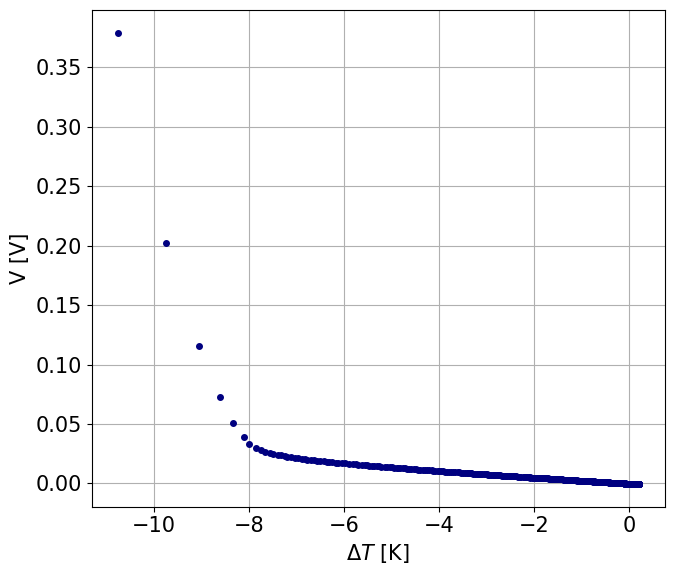

In [16]:
df = open_df('long_off.csv',V3=True)

temp1 = temps(df.V1)
temp2 = temps(df.V2)
dT = temp1-temp2
df.V3 = -df.V3

fig = plt.figure(figsize=(7,6))
plt.scatter(df.t,dT,c='navy')
plt.grid()
plt.xlabel('t [s]')
plt.ylabel(r'$\Delta T$ [K]')
plt.tight_layout()
plt.savefig('plots/long_off_T.png')
plt.show()
plt.close()

fig = plt.figure(figsize=(7,6))
plt.scatter(dT,df.V3,c='navy')
plt.grid()
plt.xlabel(r'$\Delta T$ [K]')
plt.ylabel('V [V]')
plt.tight_layout()
plt.savefig('plots/full_V_off.png')
plt.show()
plt.close()

In [17]:
# CORRER ESTE ANTES DEL SEGUNDO AJUSTE, EL OTRO ANTES DEL PRIMERO
def determine_linear_range(dT, V3, lower_start=1.35, lower_end=1.39, upper_start=1.35, upper_end=1.385, step=0.0005, min_points=50, max_points=100, durbin_threshold=[1.5,2.5]):
    if isinstance(dT, (pd.Series, pd.DataFrame)):
        dT = dT.values
    if isinstance(V3, (pd.Series, pd.DataFrame)):
        V3 = V3.values
    
    if len(dT) != len(V3):
        raise ValueError("dT and V3 must have the same length")

    best_r_squared = -np.inf
    best_model = None
    best_x = None
    best_y = None
    best_y_pred = None
    best_residuals = None
    
    lower_thresholds = np.arange(lower_start, lower_end, step)
    upper_thresholds = np.arange(upper_start, upper_end, step)
    for lower_threshold in lower_thresholds:
        for upper_threshold in upper_thresholds:
            if upper_threshold <= lower_threshold:
                continue
            
            # Filter data
            mask = (V3 > lower_threshold) & (V3 < upper_threshold)
            x = dT[mask]
            y = V3[mask]
            
            # Ensure minimum number of points
            if len(x) < min_points:
                continue
            if len(x) > max_points:
                continue
            
            # Reshape x for sklearn (2D array required)
            X = x.reshape(-1, 1)
            
            # Fit linear regression model
            model = LinearRegression()
            model.fit(X, y)
            
            # Predict y-values using the linear model
            y_pred = model.predict(X)
            
            # Calculate residuals
            residuals = y - y_pred
            
            # Check Durbin-Watson statistic
            durbin_stat = durbin_watson(residuals)
            
            # Check if Durbin-Watson statistic is below threshold
            if durbin_stat < durbin_threshold[0] or  durbin_stat > durbin_threshold[1]:
                continue  # Skip this model if autocorrelation is detected
            
            # Calculate R-squared value
            r_squared = model.score(X, y)
            
            # Update if this model is better
            if r_squared > best_r_squared:
                best_r_squared = r_squared
                best_model = model
                best_x = x
                best_y = y
                best_y_pred = y_pred
                best_residuals = residuals
    
    return best_model, best_x, best_y, best_y_pred, best_residuals, best_r_squared

Best R-squared: 0.9988871943878137
[-0.00270946]
Linear range: [-1.85028393 -1.1328106 ]


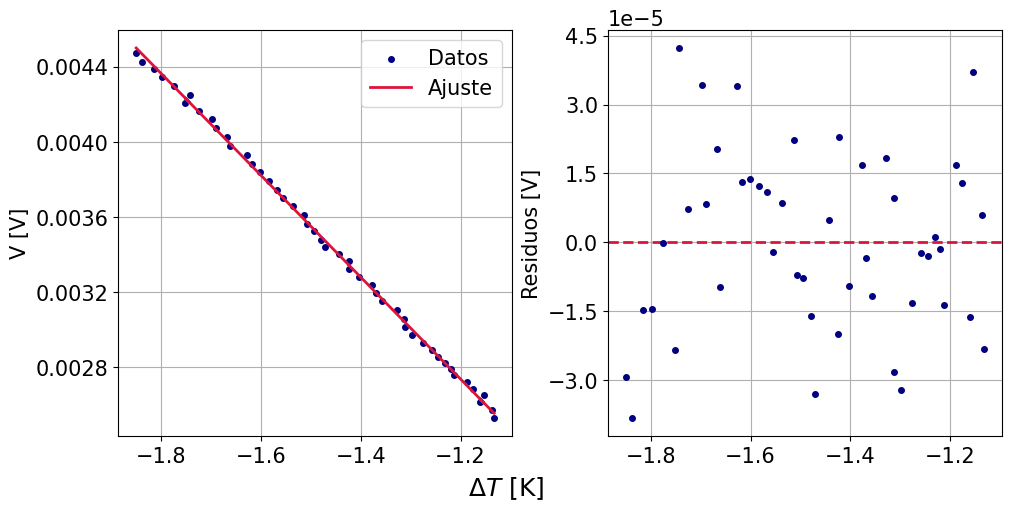

In [18]:
df = open_df('long_off.csv',V3=True)
temp1 = temps(df.V1)
temp2 = temps(df.V2)
my_dT = temp1-temp2
my_V3 = -df.V3

model, x, y, y_pred, residuals, r_squared = determine_linear_range(my_dT,my_V3,lower_start=-0.1, lower_end=0.047, upper_start=0, upper_end=0.05,min_points=30)

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True,layout='constrained')
axs = axs.flat

axs[0].scatter(x, y, c='navy', label='Datos', zorder=1)
axs[0].plot(x, y_pred, 'crimson', label='Ajuste', zorder=2)
axs[0].grid()
axs[0].legend()
axs[0].set_ylabel('V [V]')
axs[0].yaxis.set_major_locator(mpl.ticker.MaxNLocator(7))

axs[1].scatter(x, residuals, c='navy', zorder=2)
axs[1].axhline(y=0, color='crimson', linestyle='--', zorder=1)
axs[1].grid()
axs[1].set_ylabel('Residuos [V]')
axs[1].yaxis.set_major_locator(mpl.ticker.MaxNLocator(7))

fig.supxlabel(r'$\Delta T$ [K]')

linear_range_off = np.array([min(x),max(x)])

print('Best R-squared:', r_squared)

print(model.coef_)
print(f'Linear range: {linear_range_off}')

plt.savefig('plots/linear_off.png')

45
[-0.00271135 -0.00051535]
[7.03839300e-12 1.53958054e-11]
chi2 reducido = 28.781255248984653
pvalor = 5.816980057875662e-226


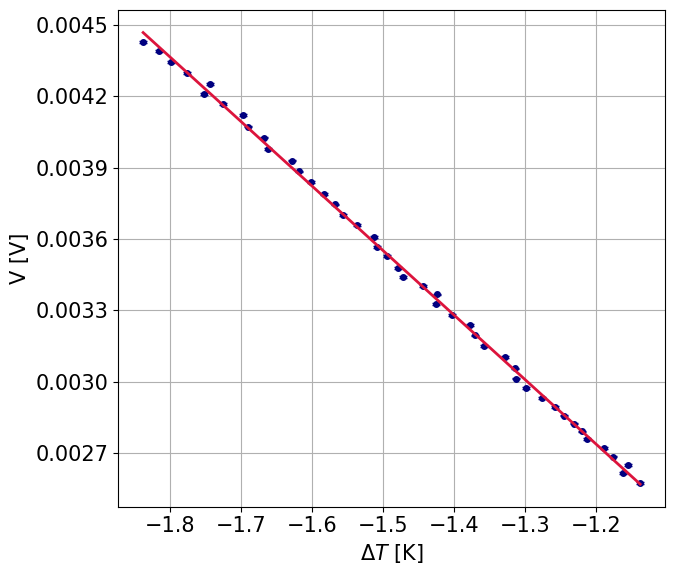

In [19]:
df = open_df('long_off.csv',V3=True)

temp1 = temps(df.V1)
temp2 = temps(df.V2)
dT = temp1-temp2
V3 = -df.V3[linear_range_off[0]<dT]
dT = dT[linear_range_off[0]<dT]
V3 = V3[dT<linear_range_off[1]]
dT = dT[dT<linear_range_off[1]]

print(len(V3))

err_V3 = error_voltajes(V3,tipo='1-year')

rel_err_2 = err_V3/V3

pars,cov = cf(lineal,dT,V3,absolute_sigma=True,sigma=err_V3)
print(pars)
print(np.diag(cov))

x_adj = np.linspace(min(dT),max(dT))
y_adj = lineal(x_adj,*pars)

fig = plt.figure(figsize=(7,6))

plt.scatter(dT,V3,c='navy',zorder=2)
plt.plot(x_adj,y_adj,c='crimson',label='Ajuste',zorder=3)
plt.errorbar(dT,V3,yerr=err_V3,fmt='none',ecolor='navy',label='Datos',zorder=1)

ax = plt.gca()
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(7))

print(f'chi2 reducido = {chi2_red(V3,err_V3,dT,lineal,pars)}')
print(f'pvalor = {pvalue(V3,err_V3,dT,lineal,pars)}')

plt.grid()
plt.xlabel(r'$\Delta T$ [K]')
plt.ylabel('V [V]')
plt.tight_layout()
plt.savefig('plots/seebeck_off.png')
plt.show()
plt.close()